In [29]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


import os
import h5py
import pdb
import glob
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *

Using TensorFlow backend.


In [2]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Directories
train_root = '/content/drive/My Drive/Colab Notebooks/data/train'
valid_root = '/content/drive/My Drive/Colab Notebooks/data/test'
test_root = '/content/drive/My Drive/Colab Notebooks/data/test'
gt_root = '/content/drive/My Drive/Colab Notebooks/data/test/label'
test_code_root = '/content/drive/My Drive/Colab Notebooks/test_code'
output_root = '/content/drive/My Drive/Colab Notebooks/output/outputs'
train_ckpt_path = '/content/drive/My Drive/Colab Notebooks/output/unet_01.hdf5'


# Variables
resume = False
input_size = (256,256,1)


# Hyperparameters
epoch = 20
lr = 0.0001
train_batch_size = 66
test_batch_size = 88
input_size = (256,256,1)

# Loss Functions

In [0]:

def bce_loss(y_true, y_pred):
    ''' Binary Cross Entropy

    Args:
        y_true (np.array): prediction
        y_pred (np.array): ground-truth
    '''
    return binary_crossentropy(y_true, y_pred)
  
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (1. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_score_loss(y_true, y_pred):
    return -iou_score(y_true, y_pred)


# Data augmentation

In [0]:


def adjust_data(image, label):
    ''' Adjust images and labels for network inputs

    Args:
        image   (np.array):   Augmented images
        label   (np.array):   Augmented labels
    '''
    image = image[0] / 255
    label = label[0]/255
    label[label>.5] =1
    label[label<=.5]=0
    return image, label


def dataset(mode, data_root, batch_size,
            image_color_mode = "grayscale",
            label_color_mode = "grayscale",
            target_size = (256,256)):

    ''' Prepare dataset ( pre-processing + augmentation(optional) )

    Args:
        args (argparse):          Arguments parsered in command-lind
        image_color_mode (str):   Image color Mode Flag
        label_color_mode (str):   Label color Mode Flag
        target_size (tuple):      Target Size
    '''
    if mode == 'train':
        shuffle=True
        # Data Augmentation (image)
        image_datagen = ImageDataGenerator(rotation_range=15,
                                           horizontal_flip=True,
                                           vertical_flip=False,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.2,
                                           zoom_range=0.1)

        # Data Augmentation (label)
        label_datagen = ImageDataGenerator(rotation_range=15,
                                           horizontal_flip=True,
                                           vertical_flip=False,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.2,
                                           zoom_range=0.1)

        print('Train Set is prepared')

    elif mode == 'valid':
        shuffle=False
        image_datagen = ImageDataGenerator()
        label_datagen = ImageDataGenerator()

        print('Validation Set is prepared')

    elif mode == 'test':
        shuffle=False
        image_datagen = ImageDataGenerator()
        label_datagen = ImageDataGenerator()

        print('Test Set is prepared')

    else:
        raise ValueError('Dataset Mode ERROR')

    # Dataloader (image)
    image_generator = image_datagen.flow_from_directory(
        data_root,
        classes=['image'],
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=1)

   # Dataloader (label)
    label_generator = label_datagen.flow_from_directory(
        data_root,
        classes=['label'],
        color_mode=label_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=1)

    data_generator = zip(image_generator, label_generator)
    for i, (image, label) in enumerate(data_generator):
        image, label = adjust_data(image, label)
        ##Save augmentated images and labels
        #for j in range(image.shape[0]):
        #    cv2.imwrite(str(i)+'-'+str(j)+'.jpg', image[j].squeeze()*255)
        #    cv2.imwrite(str(i)+'-'+str(j)+'_.jpg', label[j].squeeze()*255)
        yield (image, label)
        
        
        

def plt_img(img=None, img_path=None, save_path=None):
    ''' Plot Image using given image or image_path

    Args:
        img         (np.array)  : image to plot
        img_path    (str)       : image path to plot
        save_path   (str)       : save directory for plotted image
    '''
    if isinstance(save_path, type(None)):
        save_path = './plt_img.jpg'

    if not(isinstance(img, type(None))):
        #cv2.imwrite(save_path,img)
        plt.rcParams['figure.figsize'] = [10, 30]
        plt.imshow(img, clim=(0, 255))
        #plt.imshow(np.rot90(img, -1), clim=(0, 255))

    if not(isinstance(img_path, type(None))):
        img = cv2.imread(img_path)
        #cv2.imwrite(save_path, img)
        plt.imshow(img, clim=(0, 255))
        #plt.imshow(np.rot90(img, -1), clim=(0, 255))



def save_result(output, data_root, output_root, gt_root=None):
  
    ''' Save Prediction results overlapping on original images

    Args:
        args (argparse):    Arguments parsered in command-lind
        output (np.array):  Prediction Results by segementation model
        
    '''
    file_path = []
    file_path += glob.glob(os.path.join(data_root, 'image/*.jpg'))
    file_path = sorted(file_path)
    output = output.squeeze()
    final = None
    
    for i in range(output.shape[0]):
        if len(str(i)) == 1:
            name = '00'+str(i)
        elif len(str(i)) == 2:
            name = '0'+str(i)
        else:
            name = str(i)

        save_path = os.path.join(output_root, name+'.jpg')
        img = cv2.imread(file_path[i])
        pred = (output[i]>0.5).astype(int)
        pred = np.expand_dims(pred, axis=2)*255
        zeros = np.zeros(pred.shape)
        pred = np.concatenate((zeros,zeros,pred), axis=2)
        img = img + pred
        img = (img/(img.max()+1e-6))*255
        cv2.imwrite(save_path, img)

        # Print Example of Prediction and Ground-truth
        if (i==90 or i==63 or i==82 or i==10):
            gt_img = cv2.imread(os.path.join(gt_root, name+'.jpg'))
            img = (np.concatenate((img,gt_img),axis=1)).astype(np.uint8)
            if isinstance(final, type(None)):
                final = img
            else:
                final = np.concatenate((final, img), axis=0).astype(np.uint8)
    
    plt_img(img=final, save_path=os.path.join(test_code_root,'results.jpg'))

# Model (U-net)

In [28]:
inputs = Input(input_size)
print(inputs)

Tensor("input_2:0", shape=(?, 256, 256, 1), dtype=float32)


In [29]:
out1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
out1 = Conv2D(16, (3, 3), activation='relu', padding='same')(out1)
out2 = MaxPooling2D(pool_size=(2, 2))(out1)
print(out2)
out2 = Conv2D(32, (3, 3), activation='relu', padding='same')(out2)
out2 = Conv2D(32, (3, 3), activation='relu', padding='same')(out2)
out3 = MaxPooling2D(pool_size=(2, 2))(out2)
print(out3)
out3 = Conv2D(64, (3, 3), activation='relu', padding='same')(out3)
out3 = Conv2D(64, (3, 3), activation='relu', padding='same')(out3)
out4 = MaxPooling2D(pool_size=(2, 2))(out3)
print(out4)
out4 = Conv2D(128, (3, 3), activation='relu', padding='same')(out4)
out4 = Conv2D(128, (3, 3), activation='relu', padding='same')(out4)
out3 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(out4),out3], axis=3)
print(out3)

out3 = Conv2D(64, (3, 3), activation='relu', padding='same')(out3)
out3 = Conv2D(64, (3, 3), activation='relu', padding='same')(out3)
out2 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2),padding='same')(out3),out2], axis=3)
print(out2)
out2 = Conv2D(32, (3, 3), activation='relu', padding='same')(out2)
out2 = Conv2D(32, (3, 3), activation='relu', padding='same')(out2)
out1 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(out2),out1], axis=3)
out1 = Conv2D(16, (3, 3), activation='relu', padding='same')(out1)
print(out1)
out1 = Conv2D(16, (3, 3), activation='relu', padding='same')(out1)
print(out1)


out1 = Conv2D(1, (1, 1), activation='tanh')(out1)
print(out1)

Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("max_pooling2d_6/MaxPool:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("concatenate_4/concat:0", shape=(?, 64, 64, 192), dtype=float32)
Tensor("concatenate_5/concat:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("conv2d_29/Relu:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("conv2d_30/Relu:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("conv2d_31/Sigmoid:0", shape=(?, 256, 256, 1), dtype=float32)


In [50]:

# conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
# conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
# conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
# conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

# up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
# conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
# conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

# conv10 = Conv2D(1, (1, 1), activation='softmax')(conv9)


# Build U-Net model

fcl_size = 256
out_depth = 2

s = BatchNormalization()(inputs) # we can learn the normalization step
s = Dropout(0.5)(s)



c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

print(c4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

c5_min = Conv2D(out_depth, (3, 3), activation='relu', padding='same') (c5)

# fully connected component for spatial sensitivity
flat_c5 = Dropout(0.5)(Flatten()(c5_min))
fcl_c5 = Dropout(0.5)(Dense(fcl_size)(flat_c5))
out_shape = c5._keras_shape[1:3]+(out_depth,)
fcl_c5_imgflat = Dense(np.prod(out_shape))(fcl_c5)
fcl_img = Reshape(out_shape)(fcl_c5_imgflat)
new_c5 = concatenate([c5, fcl_img])

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (new_c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)


Tensor("conv2d_104/Relu:0", shape=(?, 32, 32, 64), dtype=float32)


# Optimizier/Loss Init

In [0]:

model = Model(inputs=[inputs], outputs=[out1])
# model = Model(inputs=[inputs], outputs=[conv10])
# model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[bce_loss])
# model.compile(optimizer=Adam(lr=lr), loss="mean_squared_error", metrics=["mse"])
model.compile(optimizer = Adam(lr=lr),loss = bce_loss, 
                   metrics = [dice_coef, bce_loss, 'mse',iou_score])
              
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=[dice_coef,bce_loss])

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

# Model Train

In [0]:
# Trainset Load
trainset = dataset(mode='train', data_root=train_root, batch_size=train_batch_size)

In [0]:
# Validationset Load
validset = dataset(mode='valid', data_root=valid_root, batch_size=train_batch_size)

In [0]:
# Model Load
model_checkpoint = ModelCheckpoint(train_ckpt_path, monitor='val_bce_loss',
                                    verbose=2, save_best_only=True)

In [35]:

# Model Train
history = model.fit_generator(trainset, steps_per_epoch=50, shuffle=False, epochs=epoch,
                    validation_data=validset, validation_steps=30,
                    callbacks=[model_checkpoint], workers=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
Train Set is prepared
Validation Set is prepared
Found 162 images belonging to 1 classes.
Found 162 images belonging to 1 classes.
Found 548 images belonging to 1 classes.
Found 548 images belonging to 1 classes.
100/100 [==============================] - 315s 3s/step - loss: 0.4509 - dice_coef: 0.0851 - bce_loss: 0.4509 - mean_squared_error: 0.1440 - iou_score: 0.0425 - val_loss: 0.1507 - val_dice_coef: 0.1791 - val_bce_loss: 0.1507 - val_mean_squared_error: 0.0452 - val_iou_score: 0.0895

Epoch 00001: val_bce_loss improved from inf to 0.15071, saving model to /content/drive/My Drive/Colab Notebooks/output/unet_01.hdf5
Epoch 2/20
100/100 [==============================] - 131s 1s/step - loss: 0.1447 - dice_coef: 0.2429 - bce_loss: 0.1447 - mean_squared_error: 0.0449 - iou_score: 0.1215 - val_loss: 0.1360 - val_dice_coef: 0.2508 - val_bce_loss: 0.1360 - val_mean_squared_error: 0.0407 - val_iou_score: 0.1254

Epoch 00002: val_bc

# Model Visualization


In [8]:
dice_coeff = history.history[ 'dice_coef']
va_dc = history.history['val_dice_coef']
loss = history.history['bce_loss']
val_loss = history.history['val_bce_loss']
mse = history.history[ 'mean_squared_error']
val_mse = history.history[  'val_mean_squared_error']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

epochs = range(len(dice_coeff))

plt.plot(epochs, dice_coeff, 'bo', label='Training dice coef loss')
plt.plot(epochs, va_dc, 'b', label='Validation dice coef loss')
plt.title('Training and validation dice loss')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training bce loss')
plt.plot(epochs, val_loss, 'b', label='Validation bce loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

plt.plot(epochs, mse, 'bo', label='Training mse ')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()

plt.show()

plt.plot(epochs, iou, 'bo', label='Training iou ')
plt.plot(epochs, val_iou, 'b', label='Validation iou')
plt.title('Training and validation iou')
plt.legend()

plt.show()

NameError: ignored

# Model Test

In [0]:
# Data Load
testset = dataset(mode='test', data_root=test_root, batch_size=test_batch_size)

In [0]:
# Model Load
model.load_weights(train_ckpt_path)

In [23]:
# Model Test
results = model.predict_generator(testset, steps=1, verbose=1)

Test Set is prepared
Found 162 images belonging to 1 classes.
Found 162 images belonging to 1 classes.
1/1 [==============================] - 36s 36s/step


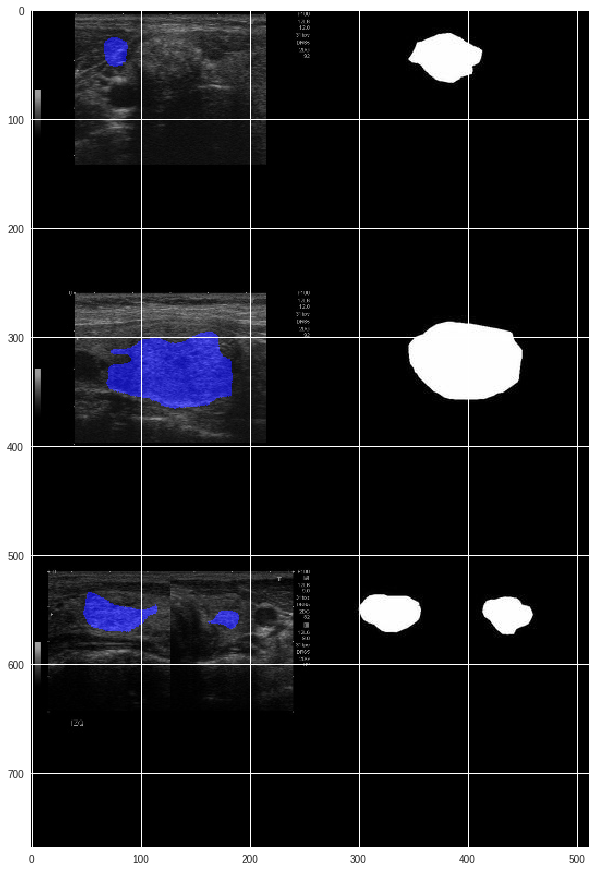

In [24]:
# Save predictions
save_result(results, test_root, output_root, gt_root)